LeNet最早发布的CNN之一

## LeNet
总体来看，LeNet由两个部分构成：
* 卷积编码器：两个卷积层
* 全连接层密集块：由三个全连接层组成

如下图所示：
<img src="md.assets/image-20220406205652130.png" alt="image-20220406205652130" style="zoom:50%;" />

简化版：
<img src="md.assets/image-20220406213400981.png" alt="image-20220406213400981" style="zoom:50%;" />



每个卷积块中的基本单元是一个卷积层，一个sigmoid激活函数和平均汇聚层。虽然ReLU的最大汇聚层更加有效，但是当时并没有出现，每个卷积层使用5X5的卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量
第一卷积层有6个输出通道，即6个卷积核，输出结果是28+2X2-5+1 = 6@28X28

通过2X2平均池化后（步幅为2)，获得的输出尺寸为：6@14X14，池化过程也被称为subsampling，采样过程

而第二个卷积层有16个输出通道，14-5+1 = 14
每个2X2池操作通过空间下采样将维数减少4倍（长宽各二倍)，卷积的输出形状由批量大小、通道数、高度和宽度决定。
为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层锁期望的二维输入，第一维代表小批量的样本索引，第二维代表每个样本的平面向量。
LeNet的稠密块有三个全连接层，分别是120，84,10个输出。

In [1]:
import torch
import torch.nn as nn

net1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),  # 第一次采样
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),  # 第二次采样
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

net2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 第一次采样
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 第二次采样
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

for layer in net2:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [3]:
import lmy

batch_size = 256
train_iter, test_iter = lmy.loadFashionMnistData(batch_size,"../lmy/data")

数据集加载成功 60000 10000
None.type: <class 'torchvision.datasets.mnist.FashionMNIST'>
None has no attribute of shape
********************


为了进行评估，我们需要修改方法，将数据集拷贝到显存中

In [4]:
import d2l


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)


def train_GPU(net, train_iter, test_iter, num_epochs, lr):
    """用GPU训练模型"""

    net.apply(init_weights)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"使用{device}进行训练")
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = lmy.Animator(xlabel='epoch',
                            xlim=[1, num_epochs],
                            ylim=[.0, 1.0],
                            legend=['train_loss', 'train_acc', 'test_acc']
                            )
    timer = lmy.Timer()
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        metric = lmy.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))

        test_acc = lmy.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        print(f"loss:{train_l:.3f},train_acc:{train_acc:.3f},test_acc:{test_acc:.3f})")
        print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {device}")


使用cpu进行训练
loss:2.318,train_acc:0.107,test_acc:0.100)
155390.8 examples/sec on cpu
loss:1.449,train_acc:0.437,test_acc:0.612)
81386.7 examples/sec on cpu
loss:0.862,train_acc:0.659,test_acc:0.648)
54553.3 examples/sec on cpu
loss:0.714,train_acc:0.720,test_acc:0.680)
41099.4 examples/sec on cpu
loss:0.636,train_acc:0.750,test_acc:0.762)
32983.9 examples/sec on cpu
loss:0.582,train_acc:0.773,test_acc:0.762)
27540.5 examples/sec on cpu
loss:0.542,train_acc:0.791,test_acc:0.790)
23673.6 examples/sec on cpu
loss:0.507,train_acc:0.805,test_acc:0.775)
20731.0 examples/sec on cpu
loss:0.482,train_acc:0.817,test_acc:0.793)
18325.8 examples/sec on cpu
loss:0.462,train_acc:0.828,test_acc:0.813)
16499.7 examples/sec on cpu


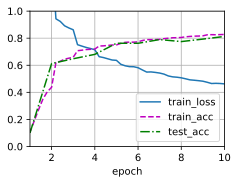

In [6]:
lr = .9
num_epochs = 10
train_GPU(net1, train_iter, test_iter, num_epochs, lr)